# Import Libraries

In [87]:
import re
import glob
import json
import string
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel, TfidfModel
from gensim.models import LdaMulticore

import spacy
import cupy as cp

import pyLDAvis
import pyLDAvis.gensim_models



warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to C:\Users\M S
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\M S
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\M S
[nltk_data]     I\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Tools

In [42]:
def summarize_categories(df, column):
    count_per_category = df[column].value_counts()
    percentage_per_category = df[column].value_counts(normalize=True) * 100
    summary = pd.DataFrame({
        'count': count_per_category,
        'percentage': percentage_per_category
    })
    return summary

# Load Data

In [43]:
sample_df = pd.read_csv('./data.csv')
sample_df.shape

(399046, 18)

## Initial Preprocessing

Clean Column Nemes

In [44]:
# Clean column names
# Remove leading/trailing whitespace, convert to lowercase, replace spaces with underscores, and remove non-word characters
sample_df.columns = (
    sample_df.columns
    .str.strip()
    .str.lower()
    .str.replace(r'\s+', '_', regex=True)
    .str.replace(r'[^\w]', '', regex=True)
)

# Display DataFrame information
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399046 entries, 0 to 399045
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date_received                 399046 non-null  object 
 1   product                       399046 non-null  object 
 2   subproduct                    399045 non-null  object 
 3   issue                         399045 non-null  object 
 4   subissue                      385096 non-null  object 
 5   consumer_complaint_narrative  239524 non-null  object 
 6   company_public_response       226285 non-null  object 
 7   company                       399046 non-null  object 
 8   state                         397871 non-null  object 
 9   zip_code                      399040 non-null  object 
 10  tags                          24390 non-null   object 
 11  consumer_consent_provided     381808 non-null  object 
 12  submitted_via                 399046 non-nul

Convert 'date' Columns to Datetime Format

In [45]:
# Convert date columns to datetime format
date_cols = ['date_received', 'date_sent_to_company']
sample_df[date_cols] = sample_df[date_cols].apply(pd.to_datetime, errors='coerce')

# Extract day, month, and year from date columns
for col in date_cols:
    sample_df[f'{col}_day'] = sample_df[col].dt.day
    sample_df[f'{col}_month'] = sample_df[col].dt.month
    sample_df[f'{col}_year'] = sample_df[col].dt.year

# Calculate the processing day as the difference between date_sent_to_company and date_received
sample_df['processing_day'] = (sample_df['date_sent_to_company'] - sample_df['date_received']).dt.days

# Display the first few rows of the DataFrame after processing dates
sample_df.head()

,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company,state,zip_code,...,timely_response,consumer_disputed,complaint_id,date_received_day,date_received_month,date_received_year,date_sent_to_company_day,date_sent_to_company_month,date_sent_to_company_year,processing_day
0,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of. 15 usc 1681 section 6...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,112XX,...,Yes,NaN,6384775,1,1,2023,1,1,2023,0
1,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,Address 's does not belong to me XXXX XXXX XXX...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28262,...,Yes,NaN,6384724,1,1,2023,1,1,2023,0
2,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,The credit reporting agency is reporting infor...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,OH,431XX,...,Yes,NaN,6384896,1,1,2023,1,1,2023,0
3,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,63366,...,Yes,NaN,6382439,1,1,2023,1,1,2023,0
4,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of The XXXX XXXX that req...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MO,655XX,...,Yes,NaN,6383627,1,1,2023,1,1,2023,0


# Exploratory Data Analysis (EDA)

| Column                         | Description                                                                 |
|--------------------------------|-----------------------------------------------------------------------------|
| Date received                  | The date when the consumer's complaint was received.                        |
| Product                        | The specific financial product or service related to the complaint.         |
| Sub-product                    | A more detailed sub-category of the product or service.                     |
| Issue                          | The main problem described in the consumer's complaint.                     |
| Sub-issue                      | Additional details or sub-category related to the main issue.               |
| Consumer complaint narrative   | A text description provided by the consumer detailing their complaint.      |
| Company public response        | The response or statement issued by the company regarding the complaint.    |
| Company                        | The name of the company being complained about.                              |
| State                          | The state of residence of the consumer.                                     |
| ZIP code                       | The postal code of the consumer's location.                                 |
| Tags                           | Additional tags or labels related to the complaint.                         |
| Consumer consent provided?     | Indicates whether the consumer consented to publish their complaint.        |
| Submitted via                  | The channel or method used to submit the complaint.                         |
| Date sent to company           | The date when the complaint was forwarded to the company for response.      |
| Company response to consumer   | The response or resolution from the company to the consumer's complaint.    |
| Timely response?               | Indicates whether the company responded in a timely manner.                 |
| Consumer disputed?             | Indicates whether the consumer disputed the company's response.             |
| Complaint ID                   | A unique identifier assigned to each complaint.                             |

## Dataset Overview

In [46]:
# Display the first few rows of the DataFrame
sample_df.head()

,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company,state,zip_code,...,timely_response,consumer_disputed,complaint_id,date_received_day,date_received_month,date_received_year,date_sent_to_company_day,date_sent_to_company_month,date_sent_to_company_year,processing_day
0,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of. 15 usc 1681 section 6...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,112XX,...,Yes,NaN,6384775,1,1,2023,1,1,2023,0
1,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,Address 's does not belong to me XXXX XXXX XXX...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28262,...,Yes,NaN,6384724,1,1,2023,1,1,2023,0
2,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,The credit reporting agency is reporting infor...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,OH,431XX,...,Yes,NaN,6384896,1,1,2023,1,1,2023,0
3,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,63366,...,Yes,NaN,6382439,1,1,2023,1,1,2023,0
4,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of The XXXX XXXX that req...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MO,655XX,...,Yes,NaN,6383627,1,1,2023,1,1,2023,0


## Create a Summary DataFrame for Non-null Values

In [47]:
# Create a summary DataFrame for non-null values
non_null_summary = pd.DataFrame({
    'feature': sample_df.columns,
    'total_non_null': sample_df.notnull().sum().values,
    'total_row': sample_df.shape[0],
    'non_null_percentage': (
        sample_df.notnull().sum().values / sample_df.shape[0] * 100
    ).round(2)
})

# Sort the summary DataFrame by non-null percentage in ascending order
non_null_summary = (
    non_null_summary
    .sort_values(by='non_null_percentage', ascending=True)
    .reset_index(drop=True)
)

# Display the non-null summary DataFrame
non_null_summary

,feature,total_non_null,total_row,non_null_percentage
0,consumer_disputed,0,399046,0.00
1,tags,24390,399046,6.11
2,company_public_response,226285,399046,56.71
3,consumer_complaint_narrative,239524,399046,60.02
4,consumer_consent_provided,381808,399046,95.68
5,subissue,385096,399046,96.50
6,state,397871,399046,99.71
7,date_received,399046,399046,100.00
8,date_sent_to_company_month,399046,399046,100.00
9,date_sent_to_company_day,399046,399046,100.00


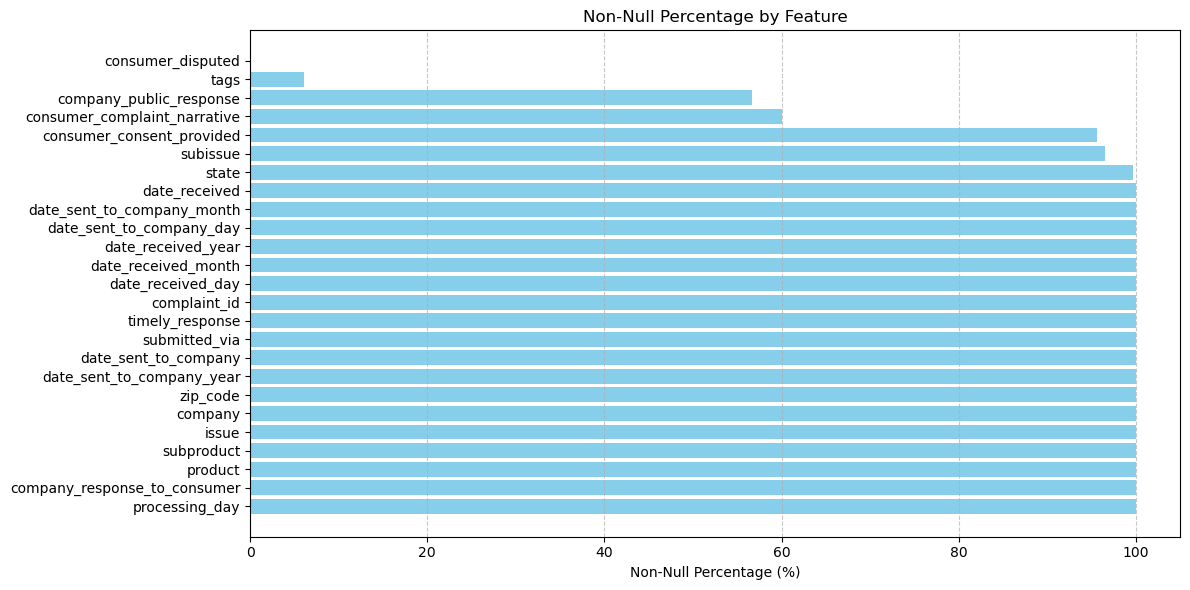

In [48]:
# Plotting the non-null percentage by feature
plt.figure(figsize=(12, 6))
plt.barh(
    non_null_summary['feature'],
    non_null_summary['non_null_percentage'],
    color='skyblue'
)
plt.xlabel('Non-Null Percentage (%)')
plt.title('Non-Null Percentage by Feature')
plt.gca().invert_yaxis()  # Highest missing at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Explore Product Column

In [49]:
# summarize the product categories
summary_product = summarize_categories(sample_df, 'product')
summary_product

,count,percentage
product,,
Credit reporting or other personal consumer reports,247784,62.094094
"Credit reporting, credit repair services, or other personal consumer reports",72712,18.221458
Debt collection,25599,6.415050
Checking or savings account,13762,3.448725
Credit card,10479,2.626013
"Money transfer, virtual currency, or money service",8038,2.014304
Mortgage,5551,1.391068
Credit card or prepaid card,5008,1.254993
Student loan,3333,0.835242


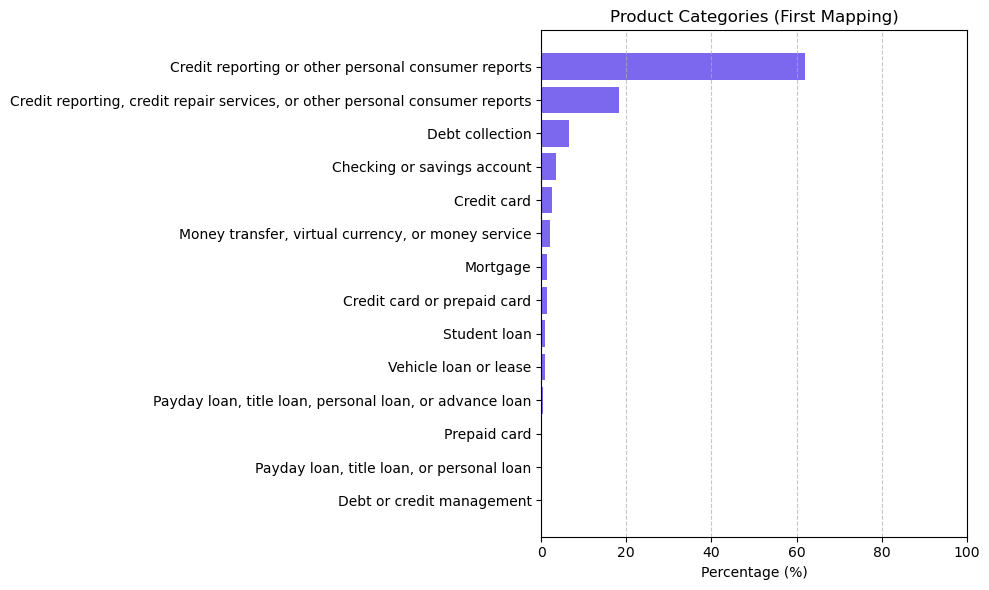

In [50]:
plt.figure(figsize=(10, 6))
plt.barh(
    summary_product.index.astype(str),
    summary_product['percentage'],
    color='mediumslateblue'
)
plt.xlabel('Percentage (%)')
plt.title('Product Categories (First Mapping)')
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insights from Unique Values in the Product Column**

1. **Category normalization is necessary**  
    Many products are essentially the same but phrased differently. Normalizing categories ensures consistency and prevents bias in analysis or modeling.

2. **Combine into _Credit reporting_**  
    - Credit reporting, credit repair services, or other personal consumer reports  
    - Credit reporting or other personal consumer reports  
    _Both refer to credit reporting services and consumer reports._

3. **Combine into _Credit card / Prepaid card_**  
    - Credit card or prepaid card  
    - Credit card  
    - Prepaid card  
    _All relate to credit or prepaid card services; only the card type differs._

4. **Combine into _Payday/Title/Personal loan_**  
    - Payday loan, title loan, or personal loan  
    - Payday loan, title loan, personal loan, or advance loan  
    _Both cover payday, title, personal, and advance loans—essentially the same category._


### First Mapping : Clean the 'product' column by mapping similar products to a common category

In [51]:
# Define a mapping dictionary for product categories
mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting',
    'Credit reporting or other personal consumer reports': 'Credit reporting',
    'Credit card or prepaid card': 'Credit card / Prepaid card',
    'Credit card': 'Credit card / Prepaid card',
    'Prepaid card': 'Credit card / Prepaid card',
    'Payday loan, title loan, or personal loan': 'Payday/Title/Personal loan',
    'Payday loan, title loan, personal loan, or advance loan': 'Payday/Title/Personal loan'
}

# Replace the 'product' column values using the mapping dictionary
sample_df['product_first_mapping'] = sample_df['product'].replace(mapping)

# Summarize the product categories after the first mapping
summary_first_product_mapping = summarize_categories(sample_df, column='product_first_mapping')

# Display the summary DataFrame after the first mapping
summary_first_product_mapping

,count,percentage
product_first_mapping,,
Credit reporting,320496,80.315553
Debt collection,25599,6.415050
Credit card / Prepaid card,16502,4.135363
Checking or savings account,13762,3.448725
"Money transfer, virtual currency, or money service",8038,2.014304
Mortgage,5551,1.391068
Student loan,3333,0.835242
Vehicle loan or lease,3297,0.826221
Payday/Title/Personal loan,2093,0.524501


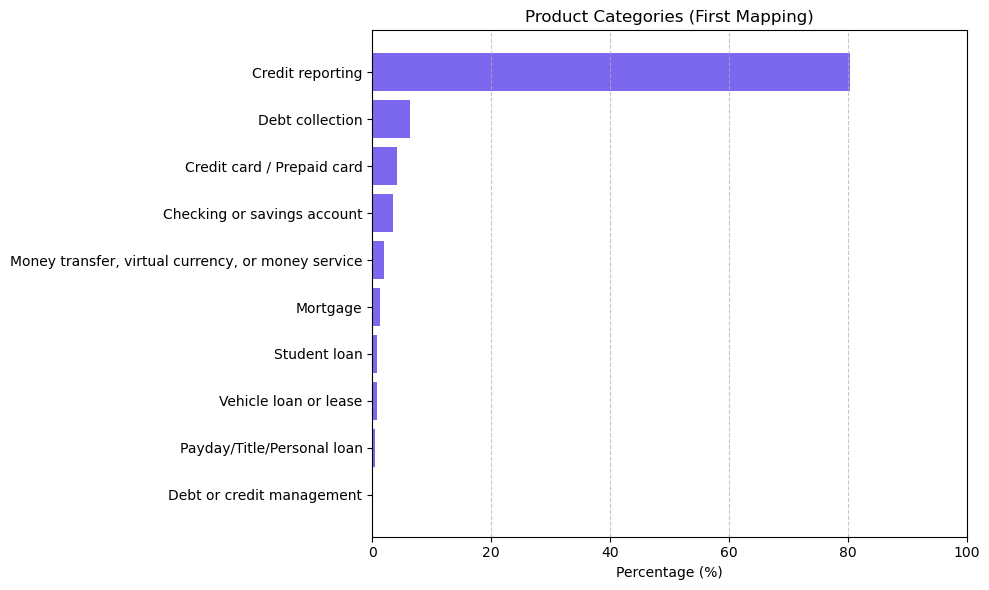

In [52]:
plt.figure(figsize=(10, 6))
plt.barh(
    summary_first_product_mapping.index.astype(str),
    summary_first_product_mapping['percentage'],
    color='mediumslateblue'
)
plt.xlabel('Percentage (%)')
plt.title('Product Categories (First Mapping)')
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insights from Unique Values in the _product first mapping_ Column**

- Categories with less than 1% of total complaints are grouped into broader categories to reduce class imbalance.
- "Debt collection" and "Debt or credit management" are merged into a single "Debt-related" category due to their similar topics.
- "Student loan," "Vehicle loan/lease," and "Payday/Title/Personal loan" are combined into an "Other" category because of their small counts and lack of strong association with major categories.

### Second Mapping : Clean the 'product_first_mapping' column by mapping similar products to a common category

In [53]:
# Define a function to group products into broader categories
def second_product_mapping(product):
    if product == 'Credit reporting':
        return 'Credit reporting'
    elif product == 'Credit card / Prepaid card':
        return 'Credit/Prepaid card'
    elif product in ['Debt collection', 'Debt or credit management']:
        return 'Debt related'
    elif product == 'Checking or savings account':
        return 'Checking/Savings account'
    elif product == 'Money transfer, virtual currency, or money service':
        return 'Money services'
    elif product == 'Mortgage':
        return 'Mortgage'
    else:
        return 'Other'  # Student loan, Vehicle loan/lease, Payday/Title/Personal loan  

# Apply the grouping function to the 'product_first_mapping' column
sample_df['product_second_mapping'] = sample_df['product_first_mapping'].apply(second_product_mapping)

# Summarize the product categories after the second mapping
summary_second_product_mapping = summarize_categories(sample_df, column='product_second_mapping')

# Display the summary DataFrame after the second mapping
summary_second_product_mapping

,count,percentage
product_second_mapping,,
Credit reporting,320496,80.315553
Debt related,25974,6.509024
Credit/Prepaid card,16502,4.135363
Checking/Savings account,13762,3.448725
Other,8723,2.185964
Money services,8038,2.014304
Mortgage,5551,1.391068


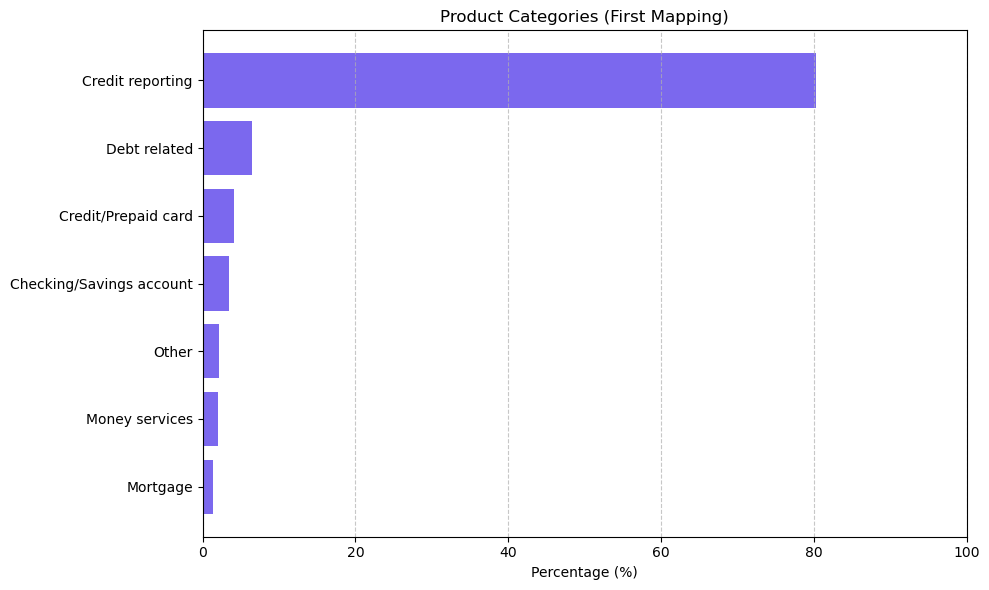

In [54]:
plt.figure(figsize=(10, 6))
plt.barh(
    summary_second_product_mapping.index.astype(str),
    summary_second_product_mapping['percentage'],
    color='mediumslateblue'
)
plt.xlabel('Percentage (%)')
plt.title('Product Categories (First Mapping)')
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Explore State Column

In [55]:
# summarize the state column
summary_state = summarize_categories(sample_df, column='state')
summary_state

,count,percentage
state,,
FL,53300,13.396302
TX,51771,13.012006
CA,39686,9.974590
GA,30413,7.643935
NY,24667,6.199748
IL,19365,4.867155
PA,17352,4.361213
NC,14088,3.540846
NJ,13270,3.335252


**Insights from Unique Values in the State Column**

Several data quality issues were identified in the `state` column, motivating normalization:

1. **Mixed formats:** Most values use US two-letter codes (e.g., NY, CA), but some use full names (e.g., "UNITED STATES MINOR OUTLYING ISLANDS").
2. **Missing values:** Some entries are NaN and require consistent handling.
3. **US territories:** Codes like PR (Puerto Rico), GU (Guam), VI (Virgin Islands), MP (Northern Mariana Islands), AS (American Samoa), and UM (Minor Outlying Islands) represent territories, not states.
4. **Military postal codes:** AE, AP, and AA indicate military addresses.
5. **Inconsistent representation:** Some locations appear in multiple formats (e.g., "UNITED STATES MINOR OUTLYING ISLANDS" vs "UM").
6. **Potential redundancy:** ZIP codes contain location info, but state normalization prevents mismatches.

---

**State Column Normalization Steps**

1. **Standardize format:** Uppercase all values and trim whitespace.
2. **Map full names to codes:** Convert names like "UNITED STATES MINOR OUTLYING ISLANDS" to "UM".
3. **Handle missing values:** Replace NaN with "Unknown".
4. **Classify state types:**
   - **State:** Standard US states and DC
   - **Territory:** PR, GU, VI, MP, AS, UM
   - **Military:** AE, AP, AA
   - **Unknown:** Missing/unrecognized entries
5. **Assign regions (US Census Bureau):**
   - **Northeast:** CT, ME, MA, NH, RI, VT, NJ, NY, PA
   - **Midwest:** IL, IN, MI, OH, WI, IA, KS, MN, MO, NE, ND, SD
   - **South:** DE, FL, GA, MD, NC, SC, VA, DC, WV, AL, KY, MS, TN, AR, LA, OK, TX
   - **West:** AZ, CO, ID, MT, NV, NM, UT, WY, AK, CA, HI, OR, WA
   - **Territory:** PR, GU, VI, MP, AS, UM
   - **Military:** AE, AP, AA
   - **Unknown:** Missing values

This normalization ensures the `state` column is consistent, analysis-ready, and suitable for grouping, visualization, and feature engineering.


### State Column Normalization

In [56]:
# State normalization mappings and groups
name_to_code = {'UNITED STATES MINOR OUTLYING ISLANDS': 'UM'}
territories = ['PR', 'GU', 'VI', 'MP', 'AS', 'UM']
military = ['AE', 'AP', 'AA']

# Define regions with their corresponding state codes
regions = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest':   ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South':     ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West':      ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

# Normalize the state column
def normalize_state(val):
    if pd.isna(val): #  
        return 'Unknown'
    val = val.strip().upper()
    return name_to_code.get(val, val)

# Map state codes to groups
def map_group(code):
    if code == 'Unknown':
        return 'Unknown'
    if code in territories:
        return 'Territory'
    if code in military:
        return 'Military'
    return 'State'

# Map state codes to regions
def map_region(code):
    for region, codes in regions.items():
        if code in codes:
            return region
    if code in territories:
        return 'Territory'
    if code in military:
        return 'Military'
    if code == 'Unknown':
        return 'Unknown'
    return 'Other'

# Apply normalization and mapping functions to the 'state' column
sample_df['state_clean'] = sample_df['state'].apply(normalize_state)
sample_df['state_group'] = sample_df['state_clean'].apply(map_group)
sample_df['region'] = sample_df['state_clean'].apply(map_region)


,count,percentage
state_clean,,
FL,53300,13.356856
TX,51771,12.973692
CA,39686,9.945219
GA,30413,7.621427
NY,24667,6.181493
...,...,...
AP,28,0.007017
GU,15,0.003759
MP,4,0.001002


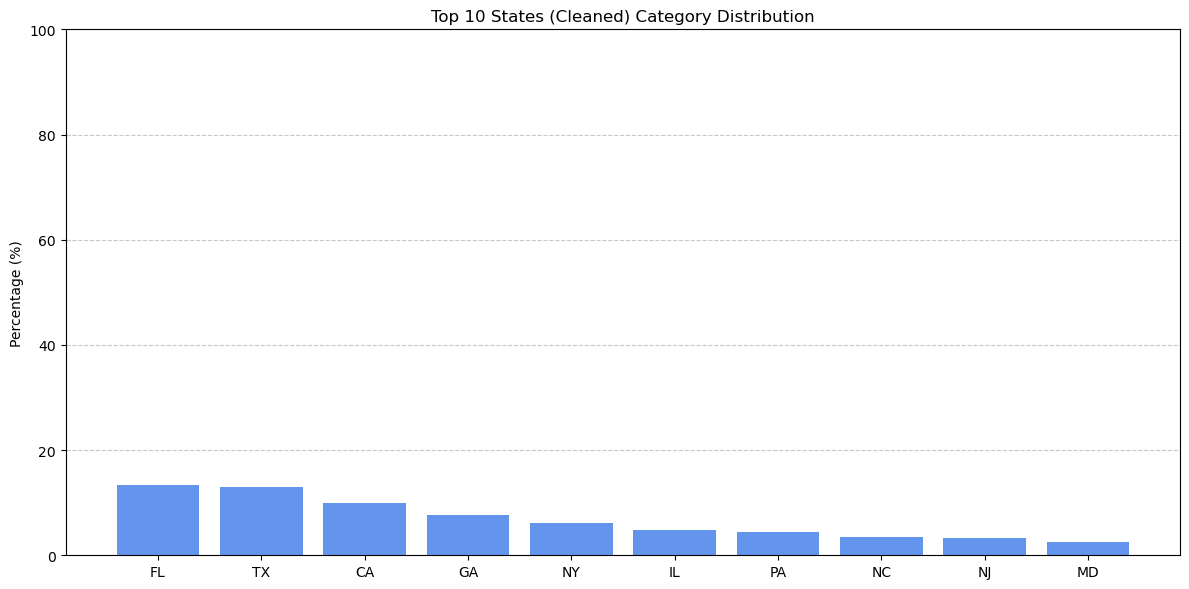

In [57]:
# Create summary for the cleaned state column
summary_state_clean = summarize_categories(sample_df, column='state_clean')
display(summary_state_clean)

# Visualize the summary
top10_state = summary_state_clean.sort_values('percentage', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(
    top10_state.index.astype(str),
    top10_state['percentage'],
    color='cornflowerblue'
)
plt.ylabel('Percentage (%)')
plt.title('Top 10 States (Cleaned) Category Distribution')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

,count,percentage
state_group,,
State,396520,99.366990
Territory,1248,0.312746
Unknown,1175,0.294452
Military,103,0.025812


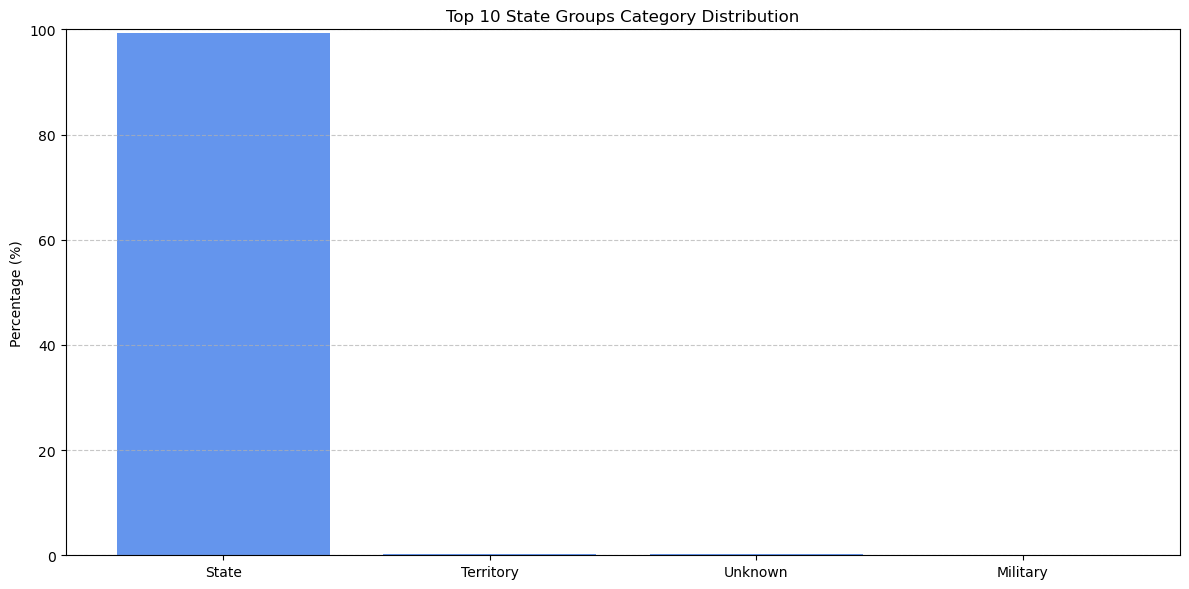

In [58]:
# Create summary for the cleaned state column
summary_state_group = summarize_categories(sample_df, column='state_group')
display(summary_state_group)

# Visualize the summary
top10_state = summary_state_group.sort_values('percentage', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(
    top10_state.index.astype(str),
    top10_state['percentage'],
    color='cornflowerblue'
)
plt.ylabel('Percentage (%)')
plt.title('Top 10 State Groups Category Distribution')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

,count,percentage
region,,
South,212859,53.341971
Northeast,64801,16.238980
West,63071,15.805446
Midwest,55789,13.980594
Territory,1248,0.312746
Unknown,1175,0.294452
Military,103,0.025812


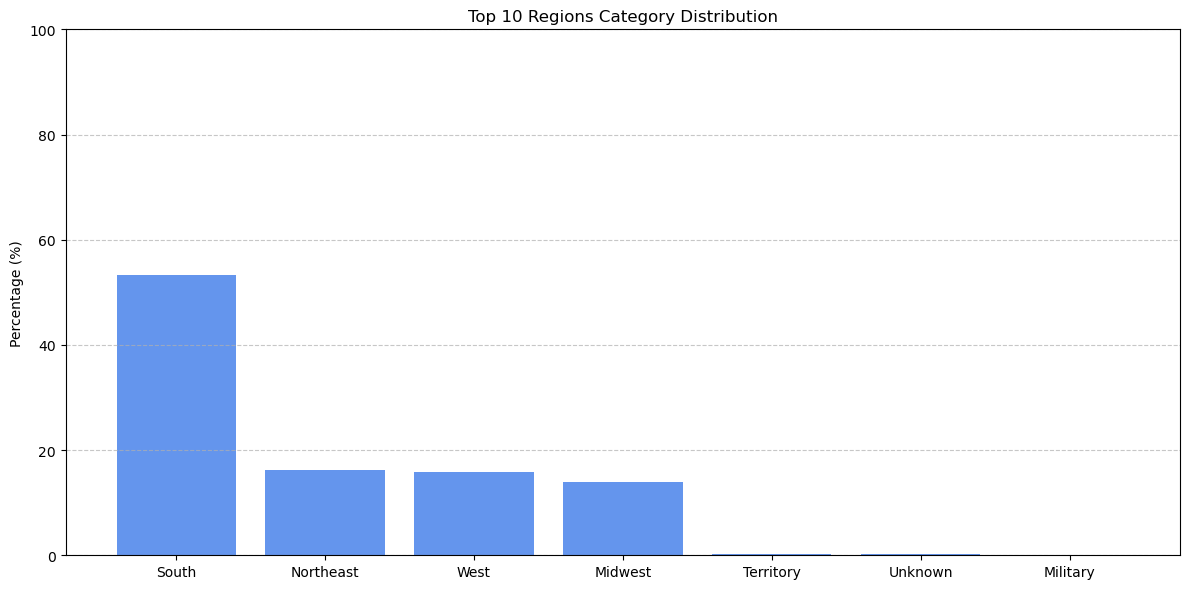

In [59]:
# Create summary for the cleaned state column
summary_region = summarize_categories(sample_df, column='region')
display(summary_region)

# Visualize the summary
top10_state = summary_region.sort_values('percentage', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(
    top10_state.index.astype(str),
    top10_state['percentage'],
    color='cornflowerblue'
)
plt.ylabel('Percentage (%)')
plt.title('Top 10 Regions Category Distribution')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analysis of the time the complaint was received by the CFPB and the time the complaint was sent to the company

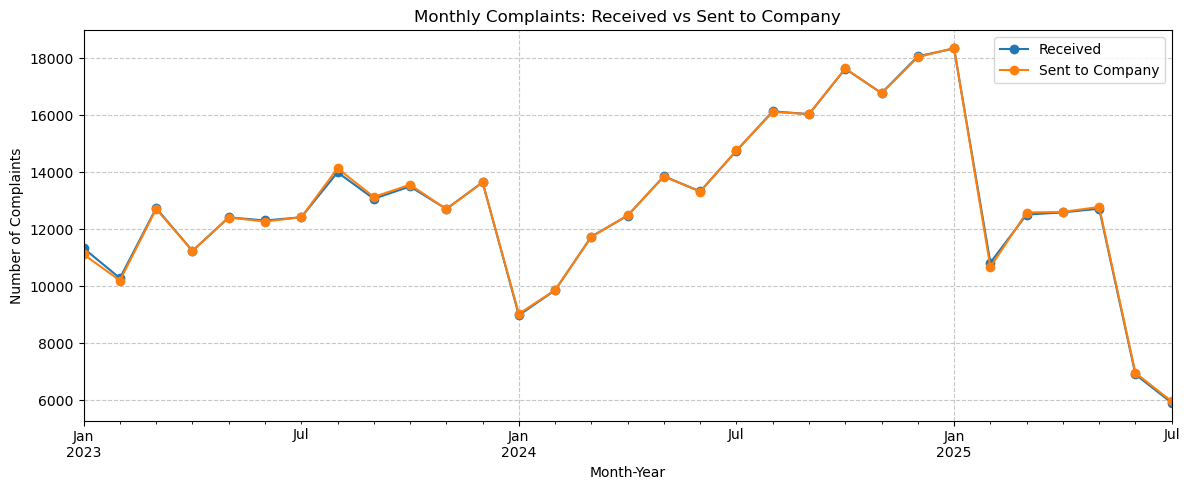

In [60]:
# Group by month and count the number of complaints received and sent to the company
monthly_received = sample_df.groupby(sample_df['date_received'].dt.to_period('M')).size()
monthly_sent = sample_df.groupby(sample_df['date_sent_to_company'].dt.to_period('M')).size()

# Create a DataFrame for monthly trends
monthly_trend = pd.DataFrame({
    'Received': monthly_received,
    'Sent to Company': monthly_sent
})

# plotting the monthly trend
plt.figure(figsize=(12, 5))
monthly_trend.plot(ax=plt.gca(), marker='o')
plt.title('Monthly Complaints: Received vs Sent to Company')
plt.xlabel('Month-Year')
plt.ylabel('Number of Complaints')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

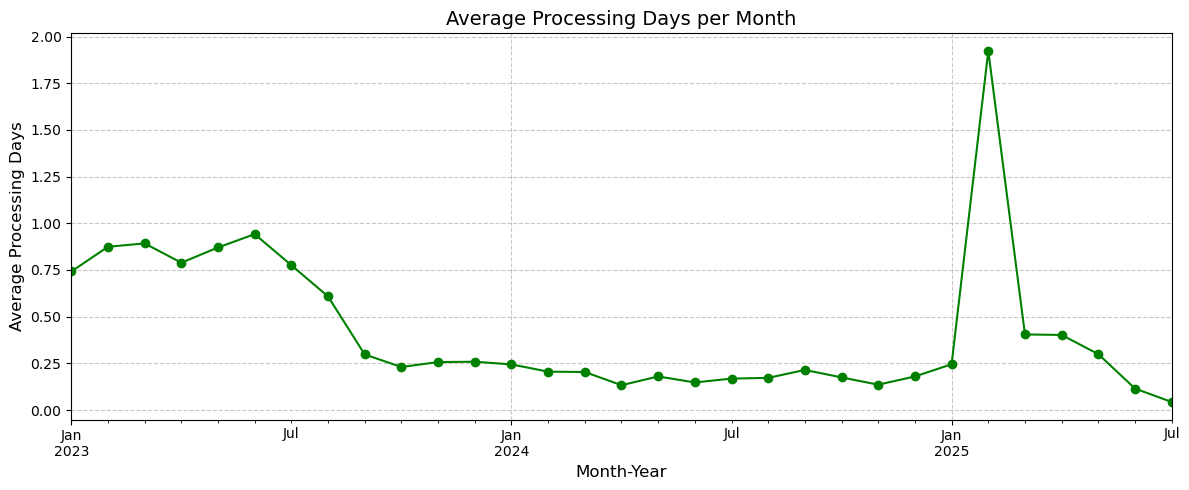

In [61]:
# Calculate the average processing days per month
avg_processing_days = sample_df.groupby(sample_df['date_received'].dt.to_period('M'))['processing_day'].mean()

# Plot the average processing days trend
plt.figure(figsize=(12, 5))
avg_processing_days.plot(marker='o', color='green')
plt.title('Average Processing Days per Month', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Average Processing Days', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

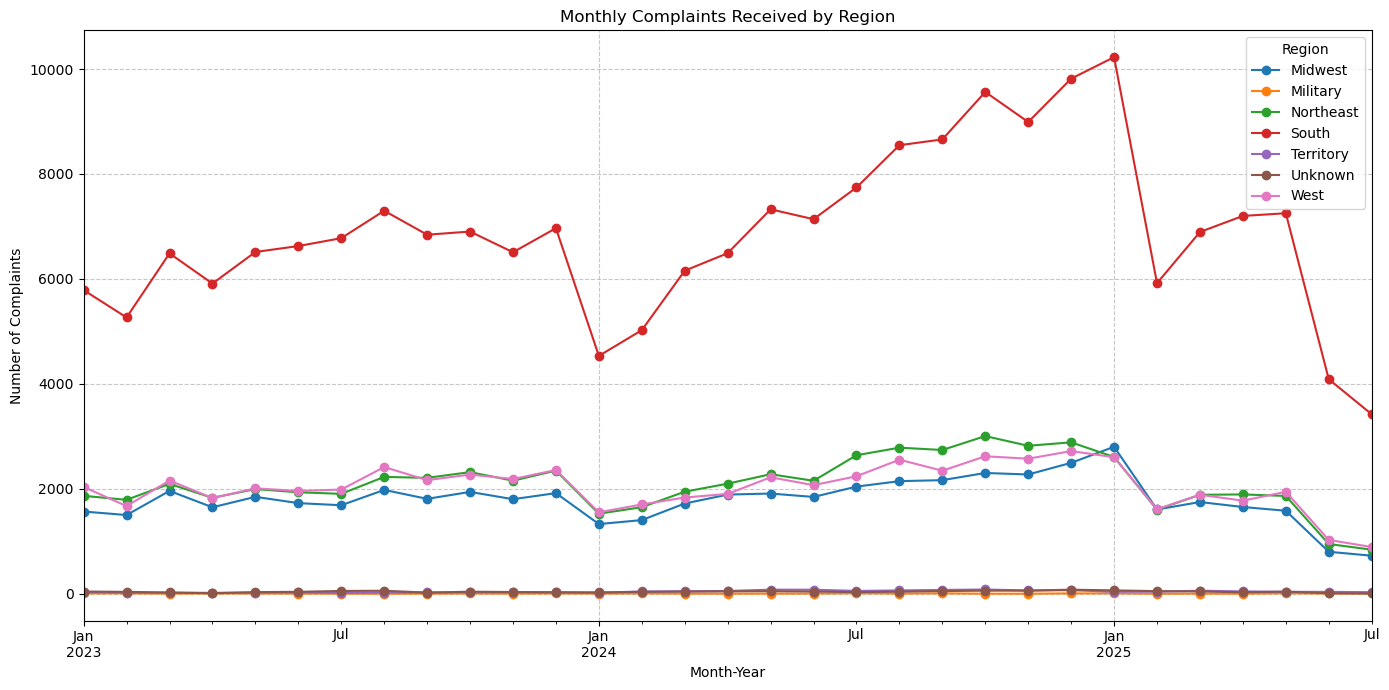

In [62]:
# Group by month-year and region, then visualize monthly complaints for each region
monthly_region = (
    sample_df
    .groupby([sample_df['date_received'].dt.to_period('M'), 'region'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(14, 7))
monthly_region.plot(ax=plt.gca(), marker='o')
plt.title('Monthly Complaints Received by Region')
plt.xlabel('Month-Year')
plt.ylabel('Number of Complaints')
plt.legend(title='Region')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Preparation For Topic Modelling

In [63]:
# Filter the DataFrame to include only rows with non-null consumer complaint narratives
consumer_complaints = sample_df[sample_df['consumer_complaint_narrative'].notnull()]

# Reset the index to ensure a clean DataFrame for further processing
consumer_complaints = consumer_complaints.reset_index(drop=True)

# Normalize the consumer complaints text
consumer_complaints = consumer_complaints['consumer_complaint_narrative'].str.lower()

# Save the consumer complaints DataFrame to a CSV file
consumer_complaints.to_csv('./consumer_complaints.csv', index=False)

consumer_complaints.shape

(239524,)

In [64]:
# Display first 100 consumer complaints with index and separator
for idx, complaint in consumer_complaints.head(100).items():
    print(f"Complaint #{idx+1}:\n{complaint}\n{'-'*60}")

Complaint #1:
xxxx is in violation of. 15 usc 1681 section 602 a, states i have the right to privacy.604 a section 2 also states a consumer reporting agency ( xxxx  ) can not furnish a consumer/credit report without my written instructions.i gave no such instructions to experian to furnish my information to xxxx xxxx which appears on my credit report.would like ths account deleted from account which is also in violation of 15 usc 1692 c and b.there was no prior consent to furnish my information to no one!!! also submitted dispute on xxxx 0n xxxx website and system is saying already in dispute.not me!!!!!
------------------------------------------------------------
Complaint #2:
address 's does not belong to me xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx 

## Clean The Texts

In [65]:
def clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(r'x{2,}', ' ', text) # remove repeated 'x's
    text = re.sub(r'(?<=\b)([a-z])\.(?=[a-z]\b)', r'\1', text) # remove single letter followed by a dot (e.g., 'a.', 'b.')
    text = re.sub(r'\.', '', text) # remove periods
    text = re.sub(r'\d+', ' ', text) # remove digits
    text = re.sub(r'\b\d{2}/\d{2}/\d{2,4}\b', ' ', text) # remove dates in the format dd/mm/yyyy or mm/dd/yyyy
    text = re.sub(r'[^\w\s]', ' ', text) # remove punctuation except for underscores
    text = re.sub(r'\s+', ' ', text).strip() # remove extra spaces
    return text

# Apply the clean_text function to the consumer complaints
consumer_complaints_cleaned = consumer_complaints.apply(clean_text)

# save the cleaned consumer complaints to a new DataFrame
consumer_complaints_cleaned.to_csv('./consumer_complaints_cleaned.csv', index=False) 

In [66]:
# Display first 100 consumer complaints cleaned with index and separator
for idx, complaint in consumer_complaints_cleaned.head(100).items():
    print(f"Complaint #{idx+1}:\n{complaint}\n{'-'*60}")

Complaint #1:
is in violation of usc section a states i have the right to privacy a section also states a consumer reporting agency can not furnish a consumer credit report without my written instructionsi gave no such instructions to experian to furnish my information to which appears on my credit reportwould like ths account deleted from account which is also in violation of usc c and bthere was no prior consent to furnish my information to no one also submitted dispute on n website and system is saying already in disputenot me
------------------------------------------------------------
Complaint #2:
address s does not belong to me inquiries do not belong to me dispute this
------------------------------------------------------------
Complaint #3:
the credit reporting agency is reporting information that is inaccurate i notified them of these inaccuracies in and they have yet to respond and it has been over days
------------------------------------------------------------
Complaint 

## Lemmatization

In [82]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    texts_out = []
    for doc in nlp.pipe(texts, batch_size=50, n_process=-1):  # -1 = gunakan semua core CPU
        texts_out.append(" ".join([tok.lemma_ for tok in doc if tok.pos_ in allowed_postags]))
    return texts_out

stop_words = set(nltk.corpus.stopwords.words("english"))
lemmatized_texts = lemmatization(consumer_complaints_cleaned)

In [83]:
# Display first 100 lemmatized consumer complaints with index and separator
for idx, complaint in enumerate(lemmatized_texts[:100]):
    print(f"Complaint #{idx+1}:\n{complaint}\n{'-'*60}")

Complaint #1:
violation usc section state right privacy section also state consumer reporting agency furnish consumer credit report write instructionsi give such instruction experian furnish information appear credit like th account delete account also violation bthere prior consent furnish information one also submit dispute n website system say already disputenot
------------------------------------------------------------
Complaint #2:
address belong inquiry belong dispute
------------------------------------------------------------
Complaint #3:
credit reporting agency report information inaccurate notify inaccuracy in yet respond day
------------------------------------------------------------
Complaint #4:
violation require financial institution company offer consumer financial product service loan financial investment advice insurance need explain information share practice customer safeguard sensitive nonpublic information datum commit identity theft receive opt notice submit n

## Generate a List of Tokenized Words from lemmatized_texts

In [84]:
# Generates a list of tokenized words from the input texts using Gensim's simple_preprocess function.
# It tokenizes each text, removes punctuation, and returns a list of lists of words.
def gen_words(texts):
    """Generates a list of tokenized words from the input texts."""
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)  # Tokenize the text and remove punctuation
        final.append(new)
    
    return final

data_words = gen_words(lemmatized_texts) # Generate a list of tokenized words from the lemmatized texts

# Display first 100 tokenized consumer complaints with index and separator
for idx, complaint in enumerate(data_words[:100]):
    print(f"Complaint #{idx+1}:\n{complaint}\n{'-'*60}")

Complaint #1:
['violation', 'usc', 'section', 'state', 'right', 'privacy', 'section', 'also', 'state', 'consumer', 'reporting', 'agency', 'furnish', 'consumer', 'credit', 'report', 'write', 'instructionsi', 'give', 'such', 'instruction', 'experian', 'furnish', 'information', 'appear', 'credit', 'like', 'th', 'account', 'delete', 'account', 'also', 'violation', 'bthere', 'prior', 'consent', 'furnish', 'information', 'one', 'also', 'submit', 'dispute', 'website', 'system', 'say', 'already', 'disputenot']
------------------------------------------------------------
Complaint #2:
['address', 'belong', 'inquiry', 'belong', 'dispute']
------------------------------------------------------------
Complaint #3:
['credit', 'reporting', 'agency', 'report', 'information', 'inaccurate', 'notify', 'inaccuracy', 'in', 'yet', 'respond', 'day']
------------------------------------------------------------
Complaint #4:
['violation', 'require', 'financial', 'institution', 'company', 'offer', 'consumer', 

## Generate Bigram & Trigram

In [85]:
# Bigrams and Trigrams

bigrams = gensim.models.Phrases(
    data_words, # Create bigrams from the tokenized words 
    min_count=5, # Minimum count of words to consider for bigram creation
    threshold=100 # Threshold for forming the phrases; higher values mean fewer phrases
    )  # Create bigrams

trigrams = gensim.models.Phrases(bigrams[data_words], threshold=100)  # Create trigrams

bigram = gensim.models.phrases.Phraser(bigrams)  # Create a Phraser for bigrams
trigram = gensim.models.phrases.Phraser(trigrams)  # Create a Phraser for trigrams

def make_bigram(texts):
    """Applies bigrams to the input texts."""
    return [bigram[doc] for doc in texts]

def make_trigram(texts):
    """Applies trigrams to the input texts."""
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigram(data_words)  # Apply bigrams to the tokenized words
data_bigrams_trigrams = make_trigram(data_bigrams)  # Apply trigrams to the bigrams

data_bigrams_trigrams[0]

['violation',
 'usc',
 'section',
 'state',
 'right',
 'privacy',
 'section',
 'also',
 'state',
 'consumer',
 'reporting',
 'agency',
 'furnish',
 'consumer',
 'credit',
 'report',
 'write',
 'instructionsi',
 'give',
 'such',
 'instruction',
 'experian',
 'furnish',
 'information',
 'appear',
 'credit',
 'like',
 'th',
 'account',
 'delete',
 'account',
 'also',
 'violation',
 'bthere',
 'prior',
 'consent',
 'furnish',
 'information',
 'one',
 'also',
 'submit',
 'dispute',
 'website',
 'system',
 'say',
 'already',
 'disputenot']

# TF-IDF Removal

In [86]:
#  TF-IDF Removal
id2word = corpora.Dictionary(data_bigrams_trigrams)  # Create a dictionary from the bigrams and trigrams
texts = data_bigrams_trigrams  # Use the bigrams and trigrams as the texts for TF-IDF

corpus = [id2word.doc2bow(text) for text in texts]  # Create a corpus from the texts
print(corpus[0][0:20])  # Display the first 20 words of the first document in the corpus

tfidf = TfidfModel(corpus, id2word=id2word)  # Create a TF-IDF model from the corpus

low_value = 0.03 # Set a low value threshold for filtering words based on TF-IDF scores
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]  # Get the bag-of-words representation of the document
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]  # Find words with TF-IDF scores below the threshold
    drops = low_value_words + words_missing_in_tfidf  # Combine low-value words with those missing in TF-IDF
    for item in drops:
        words.append(id2word[item])  # Append the words to the list of words to be removed
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]  # Find words that are missing in TF-IDF
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  # Create a new bag-of-words without low-value words
    corpus[i] = new_bow  # Update the corpus with the new bag-of-words

[(0, 2), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1)]


# Train LDA

In [90]:
# Train the LDA model
# lda_model = LdaModel(
#     corpus=corpus, # The corpus is a list of bag-of-words representations of the documents
#     id2word=id2word, # The dictionary mapping word IDs to words
#     num_topics=30, # The number of topics to extract
#     random_state=42, # Random seed for reproducibility
#     update_every=1, # Update the model every iteration
#     chunksize=100, # The number of documents to process in each training chunk
#     passes=10, # The number of passes through the corpus during training
#     alpha="auto", # Automatically adjust the alpha parameter for topic distribution
#     workers=4   # Number of worker threads to use for training (set to 4 for parallel processing)
#     )  

lda_model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=30,
    random_state=42,
    chunksize=2000,  
    passes=5,        
    iterations=30,   
    workers=5     
)

# Visualize LDA

In [91]:
pyLDAvis.enable_notebook()  # Enable interactive visualization in Jupyter Notebook
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis  # Display the visualization

c:\Anaconda\envs\topicmodeling\lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
23     0.461105 -0.018776       1        1  7.858296
8      0.164037  0.110548       2        1  5.916097
10    -0.282755  0.149894       3        1  5.159566
5      0.105393 -0.122231       4        1  5.079260
22     0.061668  0.266822       5        1  4.776154
20     0.239402 -0.149108       6        1  4.671605
18     0.214627  0.277955       7        1  4.498949
21    -0.161797 -0.035508       8        1  4.405438
17    -0.338381  0.062695       9        1  4.192018
11    -0.087773  0.424289      10        1  4.144293
0     -0.311676  0.219213      11        1  4.042951
3      0.323998  0.137243      12        1  3.440172
14     0.162234 -0.009058      13        1  3.428772
13    -0.415249  0.020092      14        1  3.393586
16    -0.050280 -0.396778      15        1  3.353189
24    -0.081705  0.182246      16        1  3.341579
19    -0.344455  0.156792      17        1  3.275470
28     0.351761  0.211219      18        1  2.497191
1     -0.216847  0.263529      19        1  2.495414
27     0.360966 -0.167263      20        1  2.453968
6      0.377018  0.038293      21        1  2.389651
2      0.044505 -0.220715      22        1  2.301512
25     0.055434  0.426179      23        1  2.283905
7     -0.323823 -0.118461      24        1  1.978229
15    -0.161112 -0.346047      25        1  1.963428
9      0.017769  0.028031      26        1  1.769239
26     0.226280 -0.370713      27        1  1.710284
4     -0.095341 -0.164393      28        1  1.444392
12     0.101904 -0.465889      29        1  1.235198
29    -0.396909 -0.390099      30        1  0.500196, topic_info=              Term           Freq          Total Category  logprob  loglift
0          account  423354.000000  423354.000000  Default  30.0000  30.0000
8           credit  348222.000000  348222.000000  Default  29.0000  29.0000
22          report  398669.000000  398669.000000  Default  28.0000  28.0000
7         consumer  321384.000000  321384.000000  Default  27.0000  27.0000
141        payment  147489.000000  147489.000000  Default  26.0000  26.0000
...            ...            ...            ...      ...      ...      ...
532   notification     135.629386    7911.913550  Topic30  -6.3543   1.2317
1122  specifically     136.349866    9131.464807  Topic30  -6.3490   1.0937
272       evidence     142.696961   17368.585864  Topic30  -6.3035   0.4962
111         remove     132.460129   90321.418504  Topic30  -6.3779  -1.2269
925    opportunity     113.617664    4704.813466  Topic30  -6.5314   1.5744

[2339 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
654        2  0.005844  ability
654        3  0.003384  ability
654        4  0.226390  ability
654        5  0.281962  ability
654        7  0.024300  ability
...      ...       ...      ...
160       27  0.005667     year
160       28  0.000187     year
160       29  0.000078     year
160       30  0.000047     year
10443      8  0.991546     zion

[13215 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 9, 11, 6, 23, 21, 19, 22, 18, 12, 1, 4, 15, 14, 17, 25, 20, 29, 2, 28, 7, 3, 26, 8, 16, 10, 27, 5, 13, 30])

# LDA Model Evaluation

In [94]:
# Print Perplexity and Coherence Score for the trained LDA model
perplexity = lda_model.log_perplexity(corpus)
print(f"LDA Model Perplexity: {perplexity:.4f}")

LDA Model Perplexity: -6.3318
